In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np 

db=mysql.connector.connect(
    host="Localhost",
    username="root",
    password="Ridhi@321",
    database="ecommerce")

cur= db.cursor()

# List all unique cities where customers are located.

In [3]:
query=''' select distinct(customer_city) from customers '''

cur.execute(query)

data=cur.fetchall()

data

s=pd.Series(data)
s.head()

0                   (franca,)
1    (sao bernardo do campo,)
2                (sao paulo,)
3          (mogi das cruzes,)
4                 (campinas,)
dtype: object

# Count the number of orders placed in 2017.

In [4]:
query=''' select count(order_id) from orders where year(order_purchase_timestamp)=2017 '''

cur.execute(query)

data=cur.fetchall()

'total orders placed in 2017 ',data[0][0]

('total orders placed in 2017 ', 315707)

# Find the total sales per category.

In [31]:
query=''' SELECT 
    Upper(products.product_category) as Category,
    ROUND(SUM(payments.payment_value), 2) AS Sales
FROM
    payments
        JOIN
    order_items ON payments.order_id = order_items.order_id
        JOIN
    products ON order_items.product_id = products.product_id
GROUP BY products.product_category;'''

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['category','sales'])
df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [4]:
query='''
SELECT 
    (SUM(CASE
        WHEN payment_installments >= 1 THEN 1
        ELSE 0
    END)) / COUNT(*) * 100
FROM
    payments;'''

cur.execute(query)

data = cur.fetchall()

'the percentage of orders that were paid in installments is ' ,data[0][0]

('the percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# Count the number of customers from each state. 

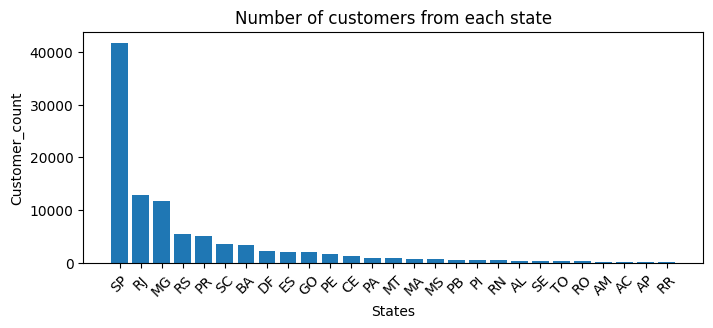

In [5]:
query=''' select customer_state,count(customer_id)
from customers group by customer_state ;'''

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=['States','Customer_count'])
df=df.sort_values(by= 'Customer_count',ascending=False)
plt.figure(figsize=(8,3))
plt.bar(df['States'],df['Customer_count'])
plt.title("Number of customers from each state")
plt.xlabel("States")
plt.ylabel("Customer_count")
plt.xticks(rotation=45)
plt.show()

# Calculate the number of orders per month in 2018.

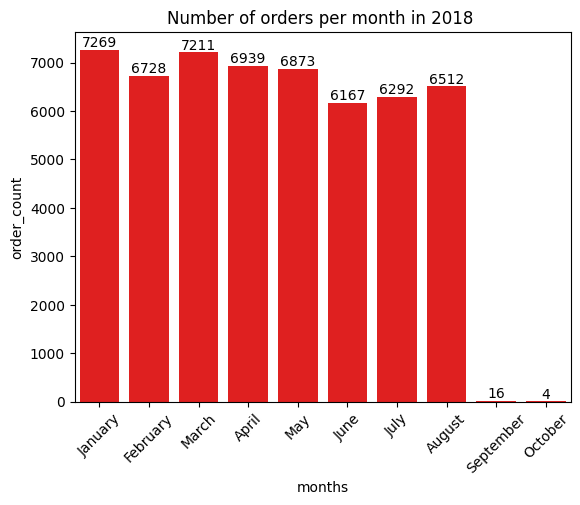

In [6]:
query=''' select monthname(order_purchase_timestamp) as months ,count(order_id) as order_count from orders 
where year(order_purchase_timestamp)=2018
group by months ;'''

cur.execute(query)

data=cur.fetchall()

data
df=pd.DataFrame(data,columns=['months','order_count'])

o=['January','February','March','April','May','June','July','August','September','October']

ax=sns.barplot(x=df['months'],y=df['order_count'],data=df,order=o,color='red')
ax.bar_label(ax.containers[0])
plt.title("Number of orders per month in 2018 ")
plt.xticks(rotation = 45)
plt.show()

# Find the average number of products per order, grouped by customer city.

In [7]:
query = '''with count_per_order as (select orders.order_id ,orders.customer_id , count(order_items.order_id) as oc
from order_items join orders on orders.order_id =order_items.order_id 
group by orders.order_id ,orders.customer_id) 

select customers.customer_city ,round(avg(count_per_order.oc),2) average_orders from customers join count_per_order 
on customers.customer_id = count_per_order.customer_id 
group by customers.customer_city order by average_orders desc; '''

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Customer city','Average Products Per Orders '])

df.head(10)

,Customer city,Average Products Per Orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [8]:
query = '''select products.product_category category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments)) * 100,2)
Percentage_of_sales from products join order_items on 
products.product_id = order_items.product_id
join payments on payments.order_id =order_items.order_id
group by category order by percentage_of_sales desc '''

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Category','Percentage of Sales'])

df

,Category,Percentage of Sales
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
...,...,...
69,House Comfort 2,0.01
70,cds music dvds,0.01
71,PC Gamer,0.01
72,Fashion Children's Clothing,0.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [9]:
query ='''select products.product_category, count(order_items.product_id),
round(avg(order_items.price),2) from products join order_items on
order_items.product_id =products.product_id group by products.product_category; '''

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Category','order_count','Average price'])

arr1=df['order_count']
arr2=df['Average price']

a=np.corrcoef([arr1,arr2])
print('The correlation between product price and number of product purchased is ' , a[0][1])


The correlation between product price and number of product purchased is  -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

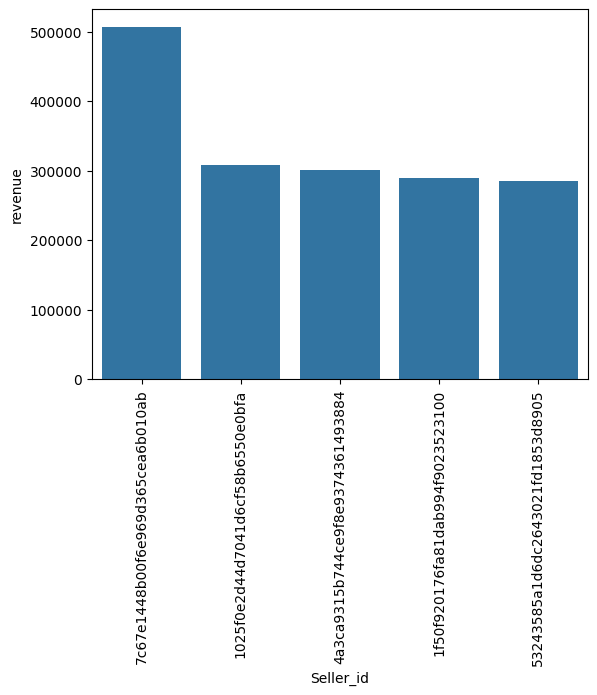

In [15]:
query='''select *,dense_rank() over (order by revenue desc) as rn from(select order_items.seller_id ,sum(payments.payment_value) as revenue
from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a
'''

cur.execute(query)

data=cur.fetchall()

df= pd.DataFrame(data ,columns=['Seller_id','revenue','Ranking'])

df=df.head()

sns.barplot(x='Seller_id',y='revenue',data=df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [16]:
query='''select customer_id ,order_purchase_timestamp , avg(payment) over
(partition by customer_id  order by order_purchase_timestamp 
rows between 2 preceding and current row ) as moving_avg  from
(select orders.customer_id ,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders on payments.order_id = orders.order_id ) as a;'''

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['customer id','Purchasing Time','Moving_avg'])
df

,customer id,Purchasing Time,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002
...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000


# Calculate the cumulative sales per month for each year

In [20]:
query=''' select years,months, payment , round(sum(payment) over (order by years, months) ,2)
cumulative_sales from(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments on
orders.order_id=payments.order_id group by years,months) as a;'''

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Years','Months','Payment','Cumulative Sales'])

df

,Years,Months,Payment,Cumulative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales.

In [21]:
query='''select years, (payment -lag(payment,1) over
(order by years) )/ lag(payment) over (order by years) * 100 from
(select year(orders.order_purchase_timestamp) as years, 
sum(payments.payment_value) as payment
from orders join payments on orders.order_id = payments.order_id
group by years ) as a ;'''

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data, columns=['Years','yay % growth'])

df

,Years,yay % growth
0,2016,NaN
1,2017,12112.703760
2,2018,20.000924


 # Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [22]:
query='''with a as (select customers.customer_id ,
min(orders.order_purchase_timestamp) as first_order from
customers join orders on 
customers.customer_id =orders.customer_id 
group by customers.customer_id)
 
, b as(select a.customer_id , count(distinct 
orders.order_purchase_timestamp) from 
a join orders on a.customer_id = orders.customer_id 
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id) )
from a left join b on a.customer_id = b.customer_id ; '''

cur.execute(query)

data=cur.fetchall()

data

[(None,)]

 # Identify the top 3 customers who spent the most money in each year.

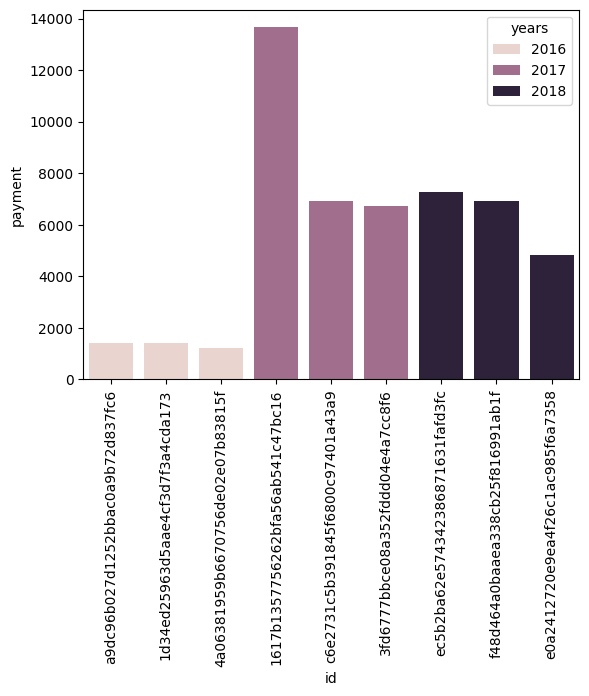

In [29]:
query='''select years,customer_id,payment ,d_rank  from
(select year(orders.order_purchase_timestamp)as years ,
orders.customer_id, sum(payments.payment_value) as payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value) desc) as d_rank
from orders join payments on orders.order_id = payments.order_id 
group by year(orders.order_purchase_timestamp) ,orders.customer_id ) as a
where d_rank <=3; '''

cur.execute(query)

data=cur.fetchall()

df= pd.DataFrame(data,columns= ['years','id','payment','rank'])

sns.barplot(x='id',y='payment',data=df ,hue='years')
plt.xticks(rotation =90)
plt.show()